## This notebook is implementing a predictive analysis model, that predicts the products ordered in users' future order based on each purchasing history.

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.api.types import CategoricalDtype
import re
import math

colors = ['#ff9999', '#66b3ff']

%matplotlib inline

<p>Memory Reduction Function (reduce_memory_usage): The core of the script is the reduce_memory_usage function, which takes a DataFrame as input and iterates through its columns to reduce memory usage.</p>

In [43]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_dtype = df[col].dtype
        
        if col_dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()
            
            if str(col_dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df

<h2 style="color:blue">Reading The Data</h2>

In [44]:
orders = pd.read_csv('orders.csv')
orders = reduce_memory_usage(orders)

products = pd.read_csv('products.csv')
products = reduce_memory_usage(products)

order_products__train = pd.read_csv('order_products__train.csv')
order_products__train = reduce_memory_usage(order_products__train)

order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__prior = reduce_memory_usage(order_products__prior)

departments = pd.read_csv('departments.csv')
departments = reduce_memory_usage(departments)

aisles = pd.read_csv('aisles.csv')
aisles = reduce_memory_usage(aisles)


### Create a DataFrame with the orders and the products that have been purchased on prior orders (op)

In [45]:
op = orders.merge(order_products__prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


### Create Predictor Variables
We at the moment are prepared to perceive and calculate predictor variables primarily based totally at the provided data.

* User predictors describing the conduct of a consumer e.g. overall variety of orders of a consumer.
* Product predictors describing traits of a product e.g. overall variety of instances a product has been purchased.
* User & product predictors describing the conduct of a consumer toward a particular product e.g. overall instances a consumer ordered a particular product.

### User predictors

In [46]:
# Calculate user total orders
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user = user.reset_index()

# Calculate user reorder ratio
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()

# Combine the tables
user_features = pd.merge(user, u_reorder, on='user_id', how='left')

# Display the combined table
user_features.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [47]:
user_total_products = op.groupby('user_id')['product_id'].count().reset_index(name='user_total_products')

# Calculate user distinct products
user_distinct_products = op.groupby('user_id')['product_id'].nunique().reset_index(name='user_distinct_products')

# Merge calculations with user features
user_features = pd.merge(user_features, user_total_products, on='user_id', how='left')
user_features = pd.merge(user_features, user_distinct_products, on='user_id', how='left')
user_features.head()

,user_id,u_total_orders,u_reordered_ratio,user_total_products,user_distinct_products
0,1,10,0.694915,59,18
1,2,14,0.476923,195,102
2,3,12,0.625000,88,33
3,4,5,0.055556,18,17
4,5,4,0.378378,37,23


### Create product predictors


In [48]:
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


### What is the probability for a product to be reordered


In [49]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [50]:
#Group products, calculate the mean of reorders
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [51]:
prd = prd.merge(p_reorder, on='product_id', how='left')

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


In [52]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


In [53]:
op

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


### Create the final ratio "uxp_order_ratio"

In [54]:
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


### Calculating the numerator - How many times a customer bought a product? ('Times_Bought_N')


In [55]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
uxp = uxp.reset_index()
times.head()


Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

### Calculating the denumerator


In [56]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


 ### The order number in which the customer first purchased the product

In [57]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [58]:
# Merge total_orders and first_order_no DataFrames on 'user_id'
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')

# Calculate Order_Range_D as the difference between total_orders and first_order_number plus 1
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1

# Merge times and span DataFrames on 'user_id' and 'product_id'
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')

# Calculate uxp_order_ratio as the ratio of Times_Bought_N to Order_Range_D
uxp_ratio['uxp_order_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D

# Drop unnecessary columns from uxp_ratio DataFrame
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)

# Display the resulting DataFrame
uxp_ratio.head()

,user_id,product_id,uxp_order_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [59]:
print(type(total_orders))
print(type(first_order_no))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Merge the final feature with uxp DataFrame

In [60]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

uxp.head()

,index,user_id,product_id,uxp_total_bought,uxp_order_ratio
0,0,1,196,10,1.000000
1,1,1,10258,9,1.000000
2,2,1,10326,1,0.166667
3,3,1,12427,10,1.000000
4,4,1,13032,3,0.333333


### Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the uxp DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called data) to have the following structure:

In [61]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user_features, on='user_id', how='left')
data.head()

,index,user_id,product_id,uxp_total_bought,uxp_order_ratio,u_total_orders,u_reordered_ratio,user_total_products,user_distinct_products
0,0,1,196,10,1.000000,10,0.694915,59,18
1,1,1,10258,9,1.000000,10,0.694915,59,18
2,2,1,10326,1,0.166667,10,0.694915,59,18
3,3,1,12427,10,1.000000,10,0.694915,59,18
4,4,1,13032,3,0.333333,10,0.694915,59,18


### Merge data with prd DataFrame
In this step we continue with our new DataFrame data and we perform a left join with prd DataFrame. The matching key here is the "product_id".

In [62]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()

,index,user_id,product_id,uxp_total_bought,uxp_order_ratio,u_total_orders,u_reordered_ratio,user_total_products,user_distinct_products,p_total_purchases,p_reorder_ratio
0,0,1,196,10,1.000000,10,0.694915,59,18,35791,0.776480
1,1,1,10258,9,1.000000,10,0.694915,59,18,1946,0.713772
2,2,1,10326,1,0.166667,10,0.694915,59,18,5526,0.652009
3,3,1,12427,10,1.000000,10,0.694915,59,18,6476,0.740735
4,4,1,13032,3,0.333333,10,0.694915,59,18,3751,0.657158


## Create train and test Data Frames

In [63]:
orders_last = orders[(orders.eval_set=='train') | (orders.eval_set=='test') ]

In [64]:
data = data.merge(orders_last, on='user_id', how='left')
data.head()

,index,user_id,product_id,uxp_total_bought,uxp_order_ratio,u_total_orders,u_reordered_ratio,user_total_products,user_distinct_products,p_total_purchases,p_reorder_ratio,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,1,196,10,1.000000,10,0.694915,59,18,35791,0.776480,1187899,train,11,4,8,14.0
1,1,1,10258,9,1.000000,10,0.694915,59,18,1946,0.713772,1187899,train,11,4,8,14.0
2,2,1,10326,1,0.166667,10,0.694915,59,18,5526,0.652009,1187899,train,11,4,8,14.0
3,3,1,12427,10,1.000000,10,0.694915,59,18,6476,0.740735,1187899,train,11,4,8,14.0
4,4,1,13032,3,0.333333,10,0.694915,59,18,3751,0.657158,1187899,train,11,4,8,14.0


In [65]:
data_train = data[data.eval_set=='train']

data_train = data_train.merge(order_products__train, on=['product_id', 'order_id'], how='left' )

data_train = data_train.drop(['order_id','eval_set', 'add_to_cart_order','index'], axis=1)
data_train = data_train.fillna(0)
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_order_ratio,u_total_orders,u_reordered_ratio,user_total_products,user_distinct_products,p_total_purchases,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10,1.000000,10,0.694915,59,18,35791,0.776480,11,4,8,14.0,1.0
1,1,10258,9,1.000000,10,0.694915,59,18,1946,0.713772,11,4,8,14.0,1.0
2,1,10326,1,0.166667,10,0.694915,59,18,5526,0.652009,11,4,8,14.0,0.0
3,1,12427,10,1.000000,10,0.694915,59,18,6476,0.740735,11,4,8,14.0,0.0
4,1,13032,3,0.333333,10,0.694915,59,18,3751,0.657158,11,4,8,14.0,1.0


In [66]:
data_test = data[data.eval_set=='test']
data_test = data_test.drop(['eval_set', 'order_id','index'], axis=1)
data_test = data_test.fillna(0)
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_order_ratio,u_total_orders,u_reordered_ratio,user_total_products,user_distinct_products,p_total_purchases,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248,1,0.090909,12,0.625,88,33,6371,0.400251,13,5,15,11.0
121,3,1005,1,0.333333,12,0.625,88,33,463,0.440605,13,5,15,11.0
122,3,1819,3,0.333333,12,0.625,88,33,2424,0.492162,13,5,15,11.0
123,3,7503,1,0.100000,12,0.625,88,33,12474,0.553551,13,5,15,11.0
124,3,8021,1,0.090909,12,0.625,88,33,27864,0.591157,13,5,15,11.0


In [67]:
data_train = data_train.set_index(['user_id', 'product_id'])
data_test = data_test.set_index(['user_id', 'product_id'])

In [68]:
data_train

uxp_total_bought  uxp_order_ratio  u_total_orders  \
user_id product_id                                                      
1       196                       10         1.000000              10   
        10258                      9         1.000000              10   
        10326                      1         0.166667              10   
        12427                     10         1.000000              10   
        13032                      3         0.333333              10   
...                              ...              ...             ...   
206209  43961                      3         0.300000              13   
        44325                      1         0.142857              13   
        48370                      1         0.333333              13   
        48697                      1         0.142857              13   
        48742                      2         0.285714              13   

                    u_reordered_ratio  user_total_products  \
user_id product_id                                           
1       196                  0.694915                   59   
        10258                0.694915                   59   
        10326                0.694915                   59   
        12427                0.694915                   59   
        13032                0.694915                   59   
...                               ...                  ...   
206209  43961                0.472868                  129   
        44325                0.472868                  129   
        48370                0.472868                  129   
        48697                0.472868                  129   
        48742                0.472868                  129   

                    user_distinct_products  p_total_purchases  \
user_id product_id                                              
1       196                             18              35791   
        10258                           18               1946   
        10326                           18               5526   
        12427                           18               6476   
        13032                           18               3751   
...                                    ...                ...   
206209  43961                           68              55371   
        44325                           68               3485   
        48370                           68               3934   
        48697                           68               9783   
        48742                           68               1723   

                    p_reorder_ratio  order_number  order_dow  \
user_id product_id                                             
1       196                0.776480            11          4   
        10258              0.713772            11          4   
        10326              0.652009            11          4   
        12427              0.740735            11          4   
        13032              0.657158            11          4   
...                             ...           ...        ...   
206209  43961              0.630583            14          6   
        44325              0.401148            14          6   
        48370              0.699288            14          6   
        48697              0.357661            14          6   
        48742              0.498549            14          6   

                    order_hour_of_day  days_since_prior_order  reordered  
user_id product_id                                                        
1       196                         8                    14.0        1.0  
        10258                       8                    14.0        1.0  
        10326                       8                    14.0        0.0  
        12427                       8                    14.0        0.0  
        13032                       8                    14.0        1.0  
...                               ...                     .

In [69]:
data_test 

uxp_total_bought  uxp_order_ratio  u_total_orders  \
user_id product_id                                                      
3       248                        1         0.090909              12   
        1005                       1         0.333333              12   
        1819                       3         0.333333              12   
        7503                       1         0.100000              12   
        8021                       1         0.090909              12   
...                              ...              ...             ...   
206208  48364                      1         0.021277              49   
        48865                      1         0.125000              49   
        49247                      1         0.022727              49   
        49385                      1         0.043478              49   
        49621                      1         0.052632              49   

                    u_reordered_ratio  user_total_products  \
user_id product_id                                           
3       248                  0.625000                   88   
        1005                 0.625000                   88   
        1819                 0.625000                   88   
        7503                 0.625000                   88   
        8021                 0.625000                   88   
...                               ...                  ...   
206208  48364                0.707533                  677   
        48865                0.707533                  677   
        49247                0.707533                  677   
        49385                0.707533                  677   
        49621                0.707533                  677   

                    user_distinct_products  p_total_purchases  \
user_id product_id                                              
3       248                             33               6371   
        1005                            33                463   
        1819                            33               2424   
        7503                            33              12474   
        8021                            33              27864   
...                                    ...                ...   
206208  48364                          198              19501   
        48865                          198                802   
        49247                          198               6292   
        49385                          198                318   
        49621                          198               4634   

                    p_reorder_ratio  order_number  order_dow  \
user_id product_id                                             
3       248                0.400251            13          5   
        1005               0.440605            13          5   
        1819               0.492162            13          5   
        7503               0.553551            13          5   
        8021               0.591157            13          5   
...                             ...           ...        ...   
206208  48364              0.530127            50          5   
        48865              0.394015            50          5   
        49247              0.654641            50          5   
        49385              0.179245            50          5   
        49621              0.643505            50          5   

                    order_hour_of_day  days_since_prior_order  
user_id product_id                                             
3       248                        15                    11.0  
        1005                       15                    11.0  
        1819                       15                    11.0  
        7503                       15                    11.0  
        8021                       15                    11.0  
...                               ...                     ...  
206208  48364                      11                     4.0  
        

[0]	train-logloss:0.32611
[10]	train-logloss:0.26907
[20]	train-logloss:0.25586
[30]	train-logloss:0.25230
[40]	train-logloss:0.25116
[50]	train-logloss:0.25069
[60]	train-logloss:0.25041
[70]	train-logloss:0.25021
[79]	train-logloss:0.25008


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

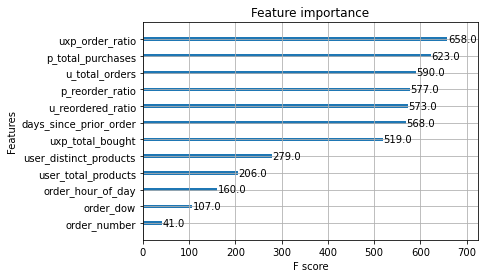

In [70]:
import xgboost
from sklearn.model_selection import train_test_split
data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)


# subsample
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered,
                                                    test_size=0.2, random_state=42)



d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)


In [71]:
xgb_params

{'objective': 'reg:logistic',
 'eval_metric': 'logloss',
 'eta': 0.1,
 'max_depth': 6,
 'min_child_weight': 10,
 'gamma': 0.7,
 'subsample': 0.76,
 'colsample_bytree': 0.95,
 'alpha': 2e-05,
 'lambda': 10}

In [72]:
# Now, create a DMatrix for the test data
d_test = xgboost.DMatrix(data_test)
data_test = data_test.reset_index()
data_test = data_test[['product_id', 'user_id']]
# Predict on the test data and set the 'reordered' column accordingly
data_test["reordered"] = (bst.predict(d_test) > 0.21).astype(int)

del bst

In [73]:
orders_test = orders[orders.eval_set=='test']

In [74]:
data_test

,product_id,user_id,reordered
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0
...,...,...,...
4833287,48364,206208,0
4833288,48865,206208,0
4833289,49247,206208,0
4833290,49385,206208,0


In [75]:
orders_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [76]:
data_test = data_test.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
data_test.head()

,product_id,user_id,reordered,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [77]:
data_test['product_id'] = data_test.product_id.astype(int)
data_test = data_test.drop('user_id', axis=1)


In [78]:
data_test

,product_id,reordered,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568
...,...,...,...
4833287,48364,0,803273
4833288,48865,0,803273
4833289,49247,0,803273
4833290,49385,0,803273


In [79]:
d = dict()
for row in data_test.itertuples():
    if row.reordered == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in data_test.order_id:
    if order not in d:
        d[order] = 'None'

In [80]:
sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

sub.to_csv('sub.csv', index=False)

In [81]:
submission = pd.read_csv("./sub.csv")
submission.head()

,order_id,products
0,2774568,9387 17668 18599 21903 22035 39190 43961 47766
1,1528013,8424 21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 35640...
3,1356845,7076 10863 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710
